# Benchmarking_v3

This notebook contains code for the Customer Benchmarking Solution as developed by CMU's capstone team for 71lbs.<br>
The code structure is outlined below:

1. Import relevant packages
2. Read in the input pickle file
3. Pre-Process data for Benchmarking:
    - Extract relevant attributes from input dataframe
    - Create pivot tables for shipment volume, weight and their respective zone-wise proportions
    - Calculate the indices required as input for the Similarity Score calculation. These include:<br>
    i. `Volumetric Scale Index (VSI)`: Quantifies customer similarity through total shipment volume<br>
    ii.`Volumetric Distribution Index (VDI)`: Quantifies customer similarity through zone-wise volume distribution<br>
    iii.`Weight Scale Index (WSI)`: Quantifies customer similarity through total shipment weight<br>
    iv. `Weight Distribution Index (WDI)`: Quantifies customer similarity through zone-wise weight distribution
4. Calculate Similarity Scores
5. Create Similarity Score Matrix
6. Identify Similar Customers
7. Calculate and display relevant KPIs

## 1. Import Relevant Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox as bc
from scipy.stats import skew
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

## 2. Read in the input pickle file

In [2]:
print(os.getcwd())

pickle_dir = os.getcwd()+ "\\Benchmarking\\test_merged_sample.pickle"
#pickle_dir = os.getcwd()+ "\\Benchmarking\\test_merged_190715_half.pickle"
#pickle_dir = os.getcwd()+ "\\Benchmarking\\test_merged_full.pickle"
print("Reading pickle file from", pickle_dir)

raw_df = pd.DataFrame()
raw_df = pd.read_pickle(pickle_dir)#test_merged_sample.pickle")
print("Initial pickle contains", len(raw_df.index), "records")

C:\Users\Shivalik\Desktop\CMU\M19\Capstone
Reading pickle file from C:\Users\Shivalik\Desktop\CMU\M19\Capstone\Benchmarking\test_merged_sample.pickle
Initial pickle contains 914372 records


## 3. Pre-process data for Benchmarking

### Extract relevant attributes from input dataframe

In [3]:
#Count the number of unique business_sids in the input dataframe
business_sid_list = raw_df.iloc[:,1].unique()
total_customers_in_data = len(business_sid_list)
print("There are" , total_customers_in_data , "unique customers in the dataset")

#Extract business_sid, shipment weight and zone to use for the benchmarking algorithm
benchmarking_df = raw_df[['business_sid', 'weight', 'zone']]
benchmarking_df.iloc[:,2] = benchmarking_df.iloc[:,2].astype('int64').astype('category') 
benchmarking_df.head()

#Optional code below - to free up memory
#del raw_df

There are 2811 unique customers in the dataset


C:\Users\Shivalik\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,business_sid,weight,zone
1232555,SOJW8FQCGI,2.0,6
1423326,XKVL2MMJL2,4.0,6
1516794,BE922CE458,10.0,8
1738984,BE922CE458,20.0,2
164310,VAQ6Q6TLDY,15.0,8


### Create pivot tables for shipment volume, weight and their respective zone-wise proportions

In [4]:
#Create pivot table for volume counts
def create_volumeCount_pivotTable(arg_df):
    tempvoldf = arg_df.groupby(['business_sid', 'zone']).count()
    tempvoldf.columns = ['Count']
    volumeCount_pivotTable = pd.pivot_table(tempvoldf, values = 'Count', index = ['business_sid'], columns = 'zone', 
                     aggfunc = np.sum, fill_value = 0)
    if len(volumeCount_pivotTable)!=total_customers_in_data:
        print("Pivot table created for a subset of all customer IDs")
    return volumeCount_pivotTable
####################################################################################################################    
#Create pivot table for volume proportions
def create_volumeProportion_pivotTable(arg_df):
    volumeProportion_pivotTable = arg_df.apply(lambda x: x/x.sum(), axis = 1)
    if len(volumeProportion_pivotTable)!=total_customers_in_data:
        print("Pivot table created for a subset of all customer IDs")
    return volumeProportion_pivotTable
####################################################################################################################
#Create pivot table for weight counts   
def create_weightCount_pivotTable(arg_df):
    tempwtdf = arg_df.groupby(['business_sid', 'zone']).sum()
    weightSum_pivotTable = pd.pivot_table(tempwtdf, values = 'weight', index = ['business_sid'], columns = 'zone',
                                         aggfunc = np.sum, fill_value = 0)
    if len(weightSum_pivotTable)!=total_customers_in_data:
        print("Pivot table created for a subset of all customer IDs")
    return weightSum_pivotTable
####################################################################################################################    
#Create pivot table for weight proportions
def create_weightProportion_pivotTable(arg_df):
    weightProportion_pivotTable= arg_df.apply(lambda x: x/x.sum(), axis = 1)
    if len(weightProportion_pivotTable)!=total_customers_in_data:
        print("Pivot table created for a subset of all customer IDs")
    return weightProportion_pivotTable
####################################################################################################################    
#Combine all pivot tables under a single function
#This will come in handy later while calculating similarity scores
def create_PivotTables(arg_df):
    a = create_volumeCount_pivotTable(arg_df)
    b = create_volumeProportion_pivotTable(a)
    c = create_weightCount_pivotTable(arg_df)
    d = create_weightProportion_pivotTable(c)
    return a,b,c,d   

In [ ]:
#Sample code for testing
'''
vc_table_test = create_volumeCount_pivotTable(benchmarking_df)
vc_table_test.head()

vp_table_test = create_volumeProportion_pivotTable(vc_table_test)
vp_table_test.head()

wc_table_test = create_weightCount_pivotTable(benchmarking_df)
wc_table_test.head()

wp_table_test = create_weightProportion_pivotTable(wc_table_test)
wp_table_test.head()
'''

In [ ]:
#These table outputs are just a sample for testing
vsitestingdf = vc_table_test.head()
vditestingdf = vp_table_test.head()
wsitestingdf = wc_table_test.head()
wditestingdf = wp_table_test.head()

In [ ]:
vsitestingdf

In [ ]:
vditestingdf

In [ ]:
wsitestingdf

In [ ]:
wditestingdf

### Calculate the indices required as input for the Similarity Score calculation

In [5]:
def calculate_VSI(sid_in_focus, vsiPivotTable, sid_count, sid_list):
    #sid_list = vsiPivotTable.index.values
    #sid_count = len(sid_list)
    vsi_list = np.empty(sid_count)
    sid_in_focus_arr = np.array(vsiPivotTable.loc[sid_in_focus])
    comparison_arr = np.array(vsiPivotTable)
    for x in range(sid_count):
        if(sid_list[x]!=sid_in_focus):
            #code for v3
            vsi_numerator = np.minimum(sid_in_focus_arr,comparison_arr[x]).sum()
            vsi_denominator = np.maximum(sid_in_focus_arr,comparison_arr[x]).sum()
            
            #code for v2
            #vsi_numerator = np.minimum(np.array(vsiPivotTable.loc[sid_in_focus]),np.array(vsiPivotTable.iloc[x])).sum()
            #vsi_denominator = np.maximum(np.array(vsiPivotTable.loc[sid_in_focus]),np.array(vsiPivotTable.iloc[x])).sum()
         
            #code for v1
            #vsi_numerator = vsiPivotTable.loc[sid_in_focus].combine(vsiPivotTable.iloc[x], min, 0)
            #vsi_denominator = vsiPivotTable.loc[sid_in_focus].combine(vsiPivotTable.iloc[x], max, 0)
            #vsi_list[x] = vsi_numerator.sum()/vsi_denominator.sum()
            
            vsi_list[x] = vsi_numerator/vsi_denominator
        else:
            vsi_list[x] = -1  # return a value of -1 when comparing a customer to themselves        
    return vsi_list
####################################################################################################################    
def calculate_VDI(sid_in_focus, vdiPivotTable, sid_count, sid_list):
    #sid_list = vdiPivotTable.index.values
    #sid_count = len(sid_list)
    vdi_list = np.empty(sid_count)
    sid_in_focus_arr = np.array(vdiPivotTable.loc[sid_in_focus])
    comparison_arr = np.array(vdiPivotTable)
    for x in range(sid_count):
        if(sid_list[x]!=sid_in_focus):
            #code for v3
            vdi_numerator = np.minimum(sid_in_focus_arr,comparison_arr[x]).sum()
            vdi_denominator = np.maximum(sid_in_focus_arr,comparison_arr[x]).sum()
            
            #code for v2
            #vdi_numerator = np.minimum(np.array(vdiPivotTable.loc[sid_in_focus]),np.array(vdiPivotTable.iloc[x])).sum()
            #vdi_denominator = np.maximum(np.array(vdiPivotTable.loc[sid_in_focus]),np.array(vdiPivotTable.iloc[x])).sum()
            
            #code for v1
            #vdi_numerator = vdiPivotTable.loc[sid_in_focus].combine(vdiPivotTable.iloc[x], min, 0)
            #vdi_denominator = vdiPivotTable.loc[sid_in_focus].combine(vdiPivotTable.iloc[x], max, 0)
            vdi_list[x] = vdi_numerator/vdi_denominator
        else:
            vdi_list[x] = -1  # return a value of -1 when comparing a customer to themselves                
    return vdi_list
####################################################################################################################    
def calculate_WSI(sid_in_focus, wsiPivotTable, sid_count, sid_list):
    #sid_list = wsiPivotTable.index.values
    #sid_count = len(sid_list)
    wsi_list = np.empty(sid_count)
    sid_in_focus_arr = np.array(wsiPivotTable.loc[sid_in_focus])
    comparison_arr = np.array(wsiPivotTable)
    for x in range(sid_count):
        if(sid_list[x]!=sid_in_focus):
            #code for v3
            wsi_numerator = np.minimum(sid_in_focus_arr,comparison_arr[x]).sum()
            wsi_denominator = np.maximum(sid_in_focus_arr,comparison_arr[x]).sum()
            
            #code for v2
            #wsi_numerator = np.minimum(np.array(wsiPivotTable.loc[sid_in_focus]),np.array(wsiPivotTable.iloc[x])).sum()
            #wsi_denominator = np.maximum(np.array(wsiPivotTable.loc[sid_in_focus]),np.array(wsiPivotTable.iloc[x])).sum()
            
            #code for v1
            #wsi_numerator = wsiPivotTable.loc[sid_in_focus].combine(wsiPivotTable.iloc[x], min, 0)
            #wsi_denominator = wsiPivotTable.loc[sid_in_focus].combine(wsiPivotTable.iloc[x], max, 0)
            wsi_list[x] = wsi_numerator/wsi_denominator
        else:
            wsi_list[x] = -1 # return a value of -1 when comparing a customer to themselves            
    return wsi_list
####################################################################################################################    
def calculate_WDI(sid_in_focus, wdiPivotTable, sid_count,sid_list):
    #sid_list = wdiPivotTable.index.values
    #sid_count = len(sid_list)
    wdi_list = np.empty(sid_count)
    sid_in_focus_arr = np.array(wdiPivotTable.loc[sid_in_focus])
    comparison_arr = np.array(wdiPivotTable)
    for x in range(sid_count):
        if(sid_list[x]!=sid_in_focus):
            #code for v3
            wdi_numerator = np.minimum(sid_in_focus_arr,comparison_arr[x]).sum()
            wdi_denominator = np.maximum(sid_in_focus_arr,comparison_arr[x]).sum()
            
            #code for v2
            #wdi_numerator = np.minimum(np.array(wdiPivotTable.loc[sid_in_focus]),np.array(wdiPivotTable.iloc[x])).sum()
            #wdi_denominator = np.maximum(np.array(wdiPivotTable.loc[sid_in_focus]),np.array(wdiPivotTable.iloc[x])).sum()
            
            #code for v1
            #wdi_numerator = wdiPivotTable.loc[sid_in_focus].combine(wdiPivotTable.iloc[x], min, 0)
            #wdi_denominator = wdiPivotTable.loc[sid_in_focus].combine(wdiPivotTable.iloc[x], max, 0)
            wdi_list[x] = wdi_numerator/wdi_denominator
        else:
            wdi_list[x] = -1 # return a value of -1 when comparing a customer to themselves               
    return wdi_list

## 4. Calculate Similarity Scores

There are 2 sets of parameters that can be changed for computing similarity scores:<br>
 1. `weight_array`: This stores weights associated with each of the 4 indices calculated above. Changing these will directly impact the Similarity Score values.
 2. `customer_subset`: This parameter controls the # of customers against which the Similarity Scores are calculated

In [6]:
#The sum of all 4 values MUST always add up to 1
#Weights are assigned in the order VSI, VDI, WSI and WDI
weight_array = np.array([0.25,0.25,0.25,0.25])
print("weight_array_sum:", weight_array.sum())

#By default, similarity scores are computed against every customer in the original dataset.
#To select a subset of customers, subset the benchmarking_df accordingly(either using head() or pandas subsetting)
#benchmarking_df has the following columns: business_sid, weight, zone

customer_subset = benchmarking_df
print("Scores will be checked against", customer_subset.iloc[:,0].nunique(), "customers")

weight_array_sum: 1.0
Scores will be checked against 2811 customers


In [7]:
allPivots = [x for x in create_PivotTables(customer_subset)]
idx_vals = allPivots[0].index.values
def calculate_similarity_score(sid_in_focus, pivotTables = allPivots, weights = weight_array): 
    if(weights.sum()!=1.0):
        print("Weights do not sum to 1. Check the weight_array parameter.")
        return -1
    sid_cnt = len(pivotTables[0].index.values)
    vsiList = calculate_VSI(sid_in_focus, vsiPivotTable= pivotTables[0], sid_count = sid_cnt, sid_list = idx_vals)
    vdiList = calculate_VDI(sid_in_focus, vdiPivotTable= pivotTables[1], sid_count = sid_cnt, sid_list = idx_vals)
    wsiList = calculate_WSI(sid_in_focus, wsiPivotTable= pivotTables[2], sid_count = sid_cnt, sid_list = idx_vals)
    wdiList = calculate_WDI(sid_in_focus, wdiPivotTable= pivotTables[3], sid_count = sid_cnt, sid_list = idx_vals) 
    ss_array = (weight_array[0]*vsiList + \
                weight_array[1]*vdiList + \
                weight_array[2]*wsiList + \
                weight_array[3]*wdiList)*100
    return np.round(ss_array,3)

In [ ]:
%%time
calculate_similarity_score('7B8E9E45F5')

In [8]:
%%time
calculate_similarity_score('7B8E9E45F5')

Wall time: 179 ms


C:\Users\Shivalik\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in minimum
C:\Users\Shivalik\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in maximum


array([19.596, 51.086, 26.118, ..., 15.817, 20.827,  8.906])

## 5. Create Similarity Score Matrix

In [9]:
#This function only takes the list of all relevant sids as an input and generates the complete similarity score table
#Note: This table takes up a large amount of memory if all business_sids are provided in allPivots

matrix_cols = allPivots[0].index.values
def create_similarity_score_table(sid_list):
    similarity_score_table = pd.DataFrame(index = sid_list, columns = matrix_cols).fillna(-1)
    for x in sid_list:
        row_vals = calculate_similarity_score(sid_in_focus = x)
        if row_vals[0]==-1:
            break
        else:
            similarity_score_table.loc[x] = row_vals
    return similarity_score_table

In [ ]:
%%time
#Sample IDs from Jose:
'''
7B8E9E45F5
E0518749DD
924052DDF5
AACOENJW
FHVD7BDTDG
'''

#ref_sids = ['004BB4E8C4', '0071F0E134','008936A589']
ref_sids = ['7B8E9E45F5','E0518749DD','924052DDF5','AACOENJW','FHVD7BDTDG']
sstable = create_similarity_score_table(ref_sids)
sstable

In [ ]:
%%time
#Sample IDs from Jose:
'''
7B8E9E45F5
E0518749DD
924052DDF5
AACOENJW
FHVD7BDTDG
'''

#ref_sids = ['004BB4E8C4', '0071F0E134','008936A589']
ref_sids = ['7B8E9E45F5','E0518749DD','924052DDF5','AACOENJW','FHVD7BDTDG']
#sstable = create_similarity_score_table('7B8E9E45F5')
sstable

In [ ]:
sstable

## 6. Identify Similar Customers

### Steps:
0. Select an SID via user input
1. Retrieve Similarity Scores(SS) against every other SID
2. Change 0 and -100 SS values to 0.0001 (needed for BoxCox normalization)
3. Calculate SS distribution skew and return normalized scores
    - if abs(skew) > 0.5, apply BoxCox transformation, else proceed to step 4
    - Apply BoxCox transformation to normalize skewed SS distribution
4. Calculate SS threshold for a given percentile using the formula:<br>
    `threshold_score = (z_percentile * scores_stdDev) + scores_mean`
5. Retrieve SIDs whose scores are greater than or equal to `threshold_score`

In [2]:
#Quickstart for full matrix analysis
matrix_dir = os.getcwd()+ "\\Benchmarking\\full_similarity_score_table.pickle"
full_ss_matrix = pd.read_pickle(matrix_dir)
#full_ss_matrix.describe()
full_ss_matrix.head(10).iloc[:,:10]

,004BB4E8C4,0071F0E134,008936A589,009F7F037A,00B9362597,00BE684C10,00D34BA35B,00E31A2581,00EF728145,010010C13F
004BB4E8C4,-100.000,12.364,31.161,27.956,19.526,19.485,28.155,19.554,17.934,44.321
0071F0E134,12.364,-100.000,24.423,11.835,37.984,26.802,8.711,47.551,33.068,19.507
008936A589,31.161,24.423,-100.000,51.938,57.435,19.029,45.774,30.227,31.619,40.284
009F7F037A,27.956,11.835,51.938,-100.000,33.888,7.944,65.099,20.470,14.790,37.378
00B9362597,19.526,37.984,57.435,33.888,-100.000,25.800,26.170,27.153,36.935,25.187
00BE684C10,19.485,26.802,19.029,7.944,25.800,-100.000,7.403,13.344,34.724,15.053
00D34BA35B,28.155,8.711,45.774,65.099,26.170,7.403,-100.000,19.550,14.964,32.566
00E31A2581,19.554,47.551,30.227,20.470,27.153,13.344,19.550,-100.000,21.625,30.230
00EF728145,17.934,33.068,31.619,14.790,36.935,34.724,14.964,21.625,-100.000,29.935
010010C13F,44.321,19.507,40.284,37.378,25.187,15.053,32.566,30.230,29.935,-100.000


In [3]:
#Convert datarame to numpy array for performance
full_ss_matrix_optimized = np.array(full_ss_matrix)
print(full_ss_matrix_optimized.shape)

#Collect all sid values
full_matrix_indices = np.array(full_ss_matrix.index.values)
print(len(full_matrix_indices), 'SIDs in the SS matrix')

(3148, 3148)
3148 SIDs in the SS matrix


### Step 0. Select an SID via user input

In [4]:
#Sample IDs from Jose:
'''
7B8E9E45F5
E0518749DD
924052DDF5
AACOENJW
FHVD7BDTDG
'''
ref_sids = ['7B8E9E45F5','E0518749DD','924052DDF5','AACOENJW','FHVD7BDTDG']

### Step 1. Retrieve Similarity Scores(SS) against every other SID

In [5]:
#%%time
def get_raw_scores(sid):
    #Retrieve the index at which the requested sid is present in the SS matrix
    test_sid_idx = np.where(full_matrix_indices==test_sid)[0][0]
    #Return the SS array
    raw_scores = full_ss_matrix_optimized[test_sid_idx]
    return raw_scores

test_sid = ref_sids[0]
raw_score_array = get_raw_scores(test_sid)
raw_score_array

array([16.012, 50.154, 27.731, ...,  3.844, 14.677, 15.928])

### Step 2: Change 0 and -100 SS values to 0.0001

In [7]:
def get_clean_scores(sid):
    #Get raw scores
    raw_score_array = get_raw_scores(sid)
    #Change NANs to 0
    raw_score_array[np.isnan(raw_score_array)]=0
    #Identify indices where scores <=0 are currently present
    dirty_score_idx = np.where(raw_score_array<=0)
    #print(dirty_score_idx)
    #Update these indices with a different value (0.0001 is chosen here)
    clean_scores = raw_score_array
    #print(clean_scores[0:5])
    np.put(clean_scores,dirty_score_idx, np.full(shape = len(dirty_score_idx),fill_value = 0.0001))
    #print(clean_scores[0:5])
    return np.array(clean_scores)

test_sid = ref_sids[0]
get_clean_scores(test_sid)

array([16.012, 50.154, 27.731, ...,  3.844, 14.677, 15.928])

### Step 3: Calculate SS distribution skew and return normalized scores

In [42]:
#Scores for some sids are normally distributed, while others have highly skewed distributions
#In order to accurately utilize a threshold score for identifiying a subset of similar customers, the scores must be 
#normally distributed

#The function below checks the score distribution's skewness(a measure of departure from normality), and if the skewness
#is above a certain threshold(0.5), then a BoxCox transformation is utilized to normalize raw score distributions

#If the scores are normally distributed(ie, skewness <0.5), the raw scores are utilized as is

def get_normalized_scores(sid):
    #Get the clean raw scores
    clean_raw_scores = get_clean_scores(sid)
    #Calculate distribution skew
    original_skew = pd.Series(clean_raw_scores).skew()
    #print(original_skew)
    #If abs(skew)>0.5, normalize the scores
    if(np.abs(original_skew)>0.5):
        #print('scores have been normalized')
        return bc(clean_raw_scores)[0]
    #Else return the clean_raw_scores
    else:
        return clean_raw_scores
test_sid = ref_sids[0]    
get_normalized_scores(test_sid)

array([ 7.27582129, 16.27163958, 10.83069173, ...,  2.08981469,
        6.81402061,  7.24721692])

### Step 4: Calculate SS threshold for a given percentile

The following z_score values are used for respective percentiles. This is reference data available from any z-score table:

`95th percentile` :1.64<br>
`90th percentile` :1.28<br>
`85th percentile` :1.04<br>
`80th percentile` :0.84<br>
`75th percentile` :0.68

In [59]:
#Initialize a dictionary to store z-score values for common percentiles. 
#These percentile values(95,90 etc.) can be offered as a filter on the user dashboard.
z_score_dict = {
    95:1.65,
    90:1.28,
    85:1.04,
    80:0.84,
    75:0.68
}

#For a given sid and percentile, this function returns both the normalized and raw threshold similarity score value. 
#All sids with a similarity score higher than the normalized threshold value will be deemed 'similar customers'
#at the given percentile(default 90th %ile) level

def ss_threshold(sid, percentile = 90):
    #First, calculate the normalized threshold score. This will be used for identifying similar customers
    normalized_ref_scores = get_normalized_scores(sid) 
    normalized_ref_mean = np.nanmean(normalized_ref_scores)
    normalized_ref_stdev = np.nanstd(normalized_ref_scores)
    normalized_threshold_score = (z_score_dict.get(percentile)*normalized_ref_stdev) + normalized_ref_mean
    
    #For reference, also return the raw threshold score. This may or may not be same as the normalized score,
    #depending on the raw score distribution for the selected sid
    raw_ref_scores = get_clean_scores(sid) 
    raw_ref_mean = np.nanmean(raw_ref_scores)
    raw_ref_stdev = np.nanstd(raw_ref_scores)
    raw_threshold_score = (z_score_dict.get(percentile)*raw_ref_stdev) + raw_ref_mean
    
    return np.round(np.array([normalized_threshold_score, raw_threshold_score]),3)
    

In [11]:
%%timeit
ss_threshold(test_sid, 95)

4.81 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
#These sample print outs show the output for an sid with a skewed SS distribution.
#Note that both the normalized and raw threshold scores are different
#The output format is [normalized_threshold , raw threshold]

test_sid = ref_sids[0]
print(test_sid)
print(ss_threshold(test_sid, 95))
print(ss_threshold(test_sid)) #default is 90
print(ss_threshold(test_sid, 85))
print(ss_threshold(test_sid, 80))
print(ss_threshold(test_sid, 75))

7B8E9E45F5
[13.941 38.476]
[12.792 34.728]
[12.047 32.296]
[11.426 30.27 ]
[10.929 28.649]


###  Step 5: Retrieve SIDs whose scores are greater than or equal to the normalized threshold score

In [45]:
#This is the function that should be executed for initializing the dashboard when a user logs in and requests 
#a list of similar customers

#This directly returns a list of ALL similar customers that are above a certain percentile threshold(default 90th %ile)

def get_similar_customers(input_sid, percentile = 90):
    #print(percentile)
    
    #Get normalized threshold score for requested sid
    normalized_threshold_score = ss_threshold(input_sid, percentile)[0]
    #print('NTS:',normalized_threshold_score)
    
    #Get index of requested sid in the full_ss_matrix
    sid_idx = np.where(full_matrix_indices==input_sid)[0][0]
    #print('sid_idx:',sid_idx)
    
    #Get normalized scores for the test_sid from the full_ss_matrix
    sid_scores = get_normalized_scores(full_ss_matrix_optimized[sid_idx])
    
    #First get all scores that are higher than the normalized threshold score
    similar_scores = full_ss_matrix_optimized[sid_idx][np.where(sid_scores>=normalized_threshold_score)[0]]
    
    #Then get a list of sids that have scores higher than the normalized threshold score
    similar_sids = full_matrix_indices[np.where(sid_scores>=normalized_threshold_score)[0]]
    
    #Sort scores in descending order
    sorted_idx = np.argsort(similar_scores)[::-1]
    
    #Sort similar_sids in descending order based on scores
    sorted_sids = similar_sids[sorted_idx]
    
    return sorted_sids

In [64]:
%%timeit
get_similar_customers(ref_sids[0], 95)

8.94 ms ± 773 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [63]:
del similar_customer_list
similar_customer_list = get_similar_customers(ref_sids[0], 95)
print('There are', len(similar_customer_list), 'similar customers', 'for sid:' ,ref_sids[0])
print('The 10 most similar customers are:')
similar_customer_list[:10]

There are 149 similar customers for sid: 7B8E9E45F5
The 10 most similar customers are:


array(['FE845213D0', '94F4546DE0', '2F49D7B816', 'EC5572BDD2',
       'D40B0745D8', '7721FE5CD5', '80BB7ED5C3', '2694F1D4B7',
       'C95B528306', 'EC1CF6CD07'], dtype=object)

# Code below is WIP - Please Ignore

8.818077860851314
21.759117725540023


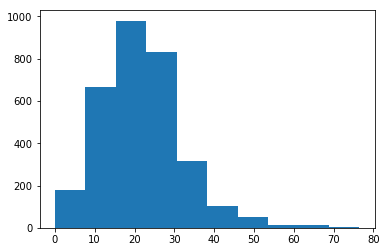

In [18]:
print(np.mean(get_normalized_scores(test_sid)))
print(np.mean(get_clean_scores(test_sid)))

#plt.hist(get_normalized_scores(test_sid));
plt.hist(get_clean_scores(test_sid));

In [19]:
test_sid_idx = np.where(full_matrix_indices==test_sid)[0][0]
full_ss_matrix.iloc[:,test_sid_idx]
print(ref_scores)
plt.hist(ref_scores);

NameError: name 'ref_scores' is not defined

717BC75192
skew 0.8516533075470624
14.711850254129606 8.993045042955247 13.654


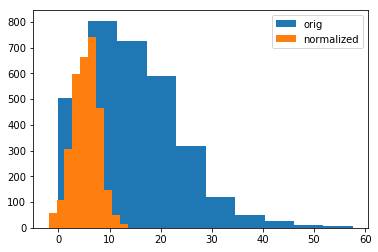

In [24]:
test_sid= np.random.choice(full_matrix_indices)
print(test_sid)
print('skew', pd.Series(get_clean_scores(test_sid)).skew())

tarrplot = get_clean_scores(test_sid)
#print(tarrplot)
#print(len(tarrplot))
print(np.nanmean(tarrplot), np.nanstd(tarrplot), np.nanmedian(tarrplot))
plt.hist(tarrplot);
plt.hist(get_normalized_scores(tarrplot))
plt.legend(['orig', 'normalized']);

In [25]:
print(test_sid)
tarrplot = clean_raw_scores(get_raw_scores(test_sid)) 
#print(tarrplot)
#print(len(tarrplot))
print(np.nanmean(tarrplot), np.nanstd(tarrplot), np.nanmedian(tarrplot))
plt.hist(tarrplot);
plt.hist(normalized_scores(tarrplot))
plt.legend(['orig', 'normalized'])

717BC75192


NameError: name 'clean_raw_scores' is not defined

In [636]:
test_sid
np.mean()

scores have been normalized


(array([4.69218026, 4.25108677, 3.99153145, ..., 1.38585634, 5.00159081,
        3.09083693]), 0.28169284978494175)

In [623]:
ref_sids = np.random.choice(full_matrix_indices, size = 10)
for a in range(len(ref_sids)):
    normalized_scores(clean_raw_scores(get_raw_scores(ref_sids[a])))

In [598]:
bc(clean_raw_scores(get_raw_scores(test_sid)))[0]
#print(len(bc(clean_raw_scores(get_raw_scores(test_sid)))))

array([ 9.46407444, 15.63377117, 21.11304211, ...,  2.20299242,
       10.15301435,  8.74271523])

9.464074444628723 [ 9.46407444 15.63377117 21.11304211 ...  2.20299242 10.15301435
  8.74271523]
15.633771167330304 0.6714225099628383


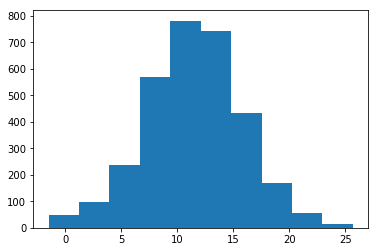

In [591]:
for x in range(2):
    print(bc(clean_raw_scores(get_raw_scores(test_sid)))[0][x], bc(clean_raw_scores(get_raw_scores(test_sid)))[x])
plt.hist(bc(clean_raw_scores(get_raw_scores(test_sid)))[0]);

In [580]:
#np.nansum(tarrplot)
raw_score_array[np.isnan(raw_score_array)] =0
np.isnan(raw_score_array)

array([False, False, False, ..., False, False, False])

[19.526 37.984 57.435 ...  3.866 21.383 17.642]
3148
26.187645338848235 12.210900701638343 25.328


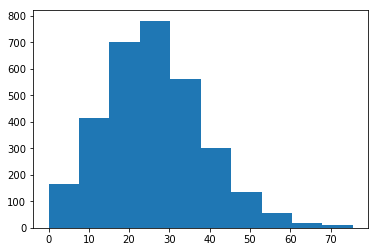

In [563]:
tarrplot = clean_raw_scores(get_raw_scores(test_sid)) 
print(tarrplot)
print(len(tarrplot))
print(np.nanmean(tarrplot), np.nanstd(tarrplot), np.nanmedian(tarrplot))
plt.hist(tarrplot);

In [538]:
%%timeit
skew(t)

571 µs ± 38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [539]:
%%timeit
pd.Series(t).skew()

396 µs ± 38.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [526]:
t = get_raw_scores(test_sid)
print('t:', t)
print(skew(t))
pd.Series(t).skew()

t: [-100.      12.364   31.161 ...   15.335   24.538   28.27 ]
nan


-0.07725394891520136

[16.012 50.154 27.731 ...  3.844 14.677 15.928]
[-100.      12.364   31.161 ...   15.335   24.538   28.27 ]
skew of normal nan
skew after removing -100 and 0 nan
skew after simple bc normalization nan
skew after lmbda = 0.5 bc normalization nan


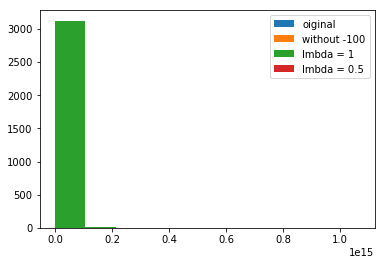

In [459]:
from scipy.stats import skew
testarr = t
print(testarr)
print(full_ss_matrix_optimized[0:,0])
print('skew of normal', skew(full_ss_matrix_optimized[0:,0]))
print('skew after removing -100 and 0', skew(testarr))
print('skew after simple bc normalization', skew(bc(testarr)[0]))
print('skew after lmbda = 0.5 bc normalization', skew(bc(testarr, lmbda = 0.5)))
plt.hist(full_ss_matrix_optimized[0:,0]);
plt.hist(testarr)
plt.hist(bc(testarr)[0]);
plt.hist(bc(testarr, lmbda = 0.5));

plt.legend([ 'oiginal','without -100','lmbda = 1', 'lmbda = 0.5'])

### Step 4: Calculate SS threshold for a given percentile

In [423]:
test_sid = '00B9362597'
test_arr2 = get_raw_scores(test_sid) 
print(test_arr2[4])

zero_elem_idx = np.where(get_raw_scores(test_sid)<=0)       
print(zero_elem_idx)

print(test_arr2[4])

65.0
(array([], dtype=int64),)
65.0


In [136]:

len(full_matrix_indices)
print(full_matrix_indices[3])

009F7F037A


In [159]:
for x in range(len(np.where(full_ss_matrix_optimized[np.where(full_matrix_indices == '004BB4E8C4')]<=0)[1])):
    print(full_ss_matrix_optimized[np.where(full_ss_matrix_optimized[np.where(full_matrix_indices == '004BB4E8C4')]<=0)[1][x]])


[-100.      12.364   31.161 ...   15.335   24.538   28.27 ]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [206]:
a = np.arange(5) 
print(a)
np.put(a, [0, 2], [-44, -55]) 
print("After put : \n", a)
print(np.full(shape = len(zero_elem_idx), fill_value = 0.0001 ))

[0 1 2 3 4]
After put : 
 [-44   1 -55   3   4]
[0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]


In [384]:
sid_idx = np.where(full_matrix_indices == '004BB4E8C4')
print(sid_idx[0])
print(full_ss_matrix_optimized[sid_idx][0])
zero_elem_idx = np.where(full_ss_matrix_optimized[sid_idx][0] <=0)[0]       
print(zero_elem_idx)
print('# of elements to change:', len(zero_elem_idx))
print(full_ss_matrix_optimized[sid_idx][0][zero_elem_idx[0]])
np.put(full_ss_matrix_optimized[sid_idx][0],zero_elem_idx, np.full(shape = len(zero_elem_idx), fill_value = 0.0001 ) )
print(full_ss_matrix_optimized[sid_idx][0])
#check
zero_elem_idx = np.where(full_ss_matrix_optimized[sid_idx][0] <=0)[0]       
print(zero_elem_idx)


[0]
[-100.      12.364   31.161 ...   15.335   24.538   28.27 ]
[0]
# of elements to change: 1
-100.0
[-100.      12.364   31.161 ...   15.335   24.538   28.27 ]
[0]


[-100.      12.364   31.161 ...   15.335   24.538   28.27 ]
4
[-100.      12.364   31.161 ...   15.335   24.538   28.27 ]
[1.0000e-05 1.2364e+01 3.1161e+01 ... 1.5335e+01 2.4538e+01 2.8270e+01]
[0]
[0]

[-100.      12.364   31.161 ...   15.335   24.538   28.27 ]
(array([0], dtype=int64),)


(array([1.000e+00, 2.400e+01, 3.500e+01, 1.170e+02, 3.240e+02, 8.590e+02,
        1.013e+03, 5.560e+02, 1.730e+02, 4.100e+01]),
 array([-1.99367544, -0.36667158,  1.26033229,  2.88733616,  4.51434003,
         6.14134389,  7.76834776,  9.39535163, 11.0223555 , 12.64935936,
        14.27636323]),
 <a list of 10 Patch objects>)

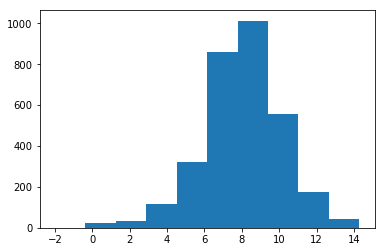

In [385]:
testarr = full_ss_matrix_optimized[sid_idx][0] 
print(testarr)
np.put(testarr,zero_elem_idx, np.full(shape = len(zero_elem_idx),fill_value = 0.00001 )) 
print(a)
print(full_ss_matrix_optimized[sid_idx][0])
print(testarr)
full_ss_matrix_optimized[sid_idx][0] = testarr
print(zero_elem_idx)
print(np.ndarray.tolist(zero_elem_idx))
print()
print(full_ss_matrix_optimized[sid_idx][0])
print(sid_idx)
#plt.hist(full_ss_matrix_optimized[sid_idx][0])
#plt.hist(testarr);
plt.hist(bc(testarr, lmbda = 0.5))

In [173]:
full_ss_matrix_optimized[np.where(full_ss_matrix_optimized[np.where(full_matrix_indices == '004BB4E8C4')]<=0)[1][sid_idx]][0]

array([-100.   ,   12.364,   31.161, ...,   15.335,   24.538,   28.27 ])

In [127]:
print(len(full_ss_matrix_optimized), full_ss_matrix_optimized.shape, 3148*3148 - 9820300)
full_ss_matrix_optimized = np.nan_to_num(full_ss_matrix_optimized)
np.count_nonzero(np.isnan(full_ss_matrix_optimized))

3148 (3148, 3148) 89604


0

In [144]:
bc(np.array([0.00001]), lmbda = 0.5)

array([-1.99367544])

In [128]:
full_ss_matrix_optimized = np.nan_to_num(full_ss_matrix_optimized)
full_ss_matrix_bctransform = bc(full_ss_matrix_optimized[full_ss_matrix_optimized>0],lmbda = 0.5)
full_ss_matrix_bctransform[1:,0]

ValueError: Data must be positive.

### Measuring Skewness

In [471]:
type(testarr)

numpy.ndarray

In [469]:
skew([0,1,2,3,4,500,6])

2.040770159656908

In [467]:
skew(bc(testarr)[0])
#bc(testarr, lmbda = 0.5)

nan

[31.161 27.956 19.526 ... 15.335 24.538 28.27 ]
[31.161 27.956 19.526 ... 15.335 24.538 28.27 ]
skew of normal nan
skew after removing -100 and 0 nan
skew after simple bc normalization nan
skew after lmbda = 0.5 bc normalization nan


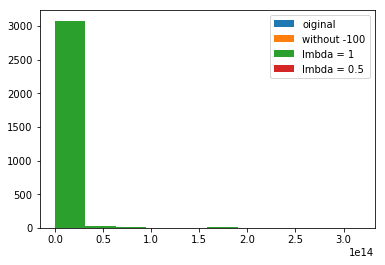

In [470]:
from scipy.stats import skew
testarr = full_ss_matrix_optimized[2:,0]

print(testarr)
print(full_ss_matrix_optimized[2:,0])
print('skew of normal', skew(full_ss_matrix_optimized[2:,0]))
print('skew after removing -100 and 0', skew(testarr))
print('skew after simple bc normalization', skew(bc(testarr)[0]))
print('skew after lmbda = 0.5 bc normalization', skew(bc(testarr, lmbda = 0.5)))
plt.hist(full_ss_matrix_optimized[0:,0]);
plt.hist(testarr)
plt.hist(bc(testarr)[0]);
plt.hist(bc(testarr, lmbda = 0.5));

plt.legend([ 'oiginal','without -100','lmbda = 1', 'lmbda = 0.5'])

In [ ]:
#code to find highest score in table
#np.max(sstable.max(axis = 1))

In [ ]:
raw_df.columns

In [ ]:
ref_sids = ['7B8E9E45F5','E0518749DD','924052DDF5','AACOENJW','FHVD7BDTDG']
ref_sids = sstable.T.sample(5).index.values
ref_sids

In [ ]:
np.where(np.array(arr)<=0)

In [ ]:
print(np.sort(arr))

In [ ]:
ref_sids = full_ss_matrix.sample(5).index.values
arr = full_ss_matrix.loc[ref_sids[0]]
print(ref_sids[0])


bc transform 8.097259967704678 2.667408177277172
regular 27.16329089751746 12.994519060327098
bc transform 5.0243163189604365 1.8648563009293586
regular 13.175258752387013 6.853290580533776
bc transform 6.267105137440543 2.4668710131624625
regular 18.607619987269295 10.427253623921121
bc transform 8.60532810851486 2.869062094498434
regular 30.176125397835726 14.71904376409278
bc transform 8.621366792828335 2.652228140711697
regular 29.961936664544833 13.816264240159617


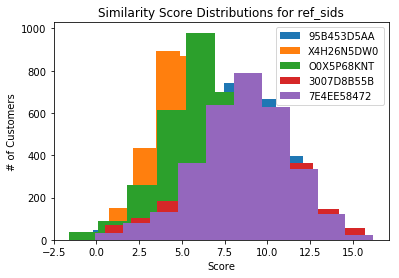

In [301]:
#ref_sids = full_ss_matrix.sample(5).index.values
for a in range(len(ref_sids)):
    arr = full_ss_matrix.loc[ref_sids[a]]
    arr_pos = arr[arr>0]#arr[arr!=-100]
    arr_bc = bc(arr_pos, lmbda = 0.5)
    #plt.figure()
    #plt.boxplot(arr_bc)
    #plt.hist(arr[arr!=-100])
    #plt.figure()
    plt.hist(arr_bc)
    plt.title('Similarity Score Distributions for ref_sids')# + str(ref_sids[a]))
    plt.ylabel('# of Customers')
    plt.xlabel('Score')
    plt.legend(ref_sids)
    print('bc transform',np.mean(arr_bc),np.std(arr_bc))
    print('regular',np.mean(arr[arr!=-100]),np.std(arr[arr!=-100]))
    '''
    print('For',ref_sids[a],':')
    print('mean:', np.mean(arr))
    print('median:',np.median(arr))
    print('std dev', np.std(arr), '\n')
    '''

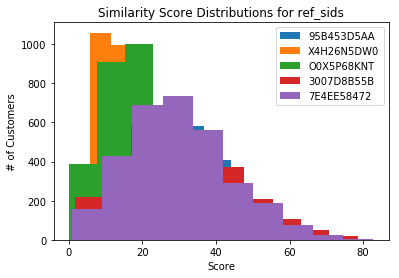

In [302]:
#ref_sids = full_ss_matrix.sample(5).index.values
plt.clf()
for a in range(len(ref_sids)):
    arr = full_ss_matrix.loc[ref_sids[a]]
    #arr_pos = arr[arr>0]#arr[arr!=-100]
    #arr_bc = bc(arr_pos, lmbda = 0.5)
    #plt.figure()
    #plt.boxplot(arr[arr>0])
    #print(arr[arr!=-100])
    plt.hist(arr[arr!=-100])
    #plt.figure()
    #plt.hist(arr_bc)
    plt.title('Similarity Score Distributions for ref_sids')# + str(ref_sids[a]))
    plt.ylabel('# of Customers')
    plt.xlabel('Score')
    plt.legend(ref_sids)
    '''
    print('For',ref_sids[a],':')
    print('mean:', np.mean(arr))
    print('median:',np.median(arr))
    print('std dev', np.std(arr), '\n')
    '''

In [28]:
t = benchmarking_df[benchmarking_df['business_sid']==ref_sids[0]]
create_volumeCount_pivotTable(t)

Pivot table created for a subset of all customer IDs


zone,0,1,2,3,4,5,6,7,8,9
business_sid,,,,,,,,,,
PGQJF2XJOP,0,0,1,2,5,4,4,0,1,0


In [41]:
ref_sids

array(['PGQJF2XJOP', '8F7CFF1857', 'DC72AC7CDB', 'O27BMPS968',
       'A132B9207D'], dtype=object)

In [56]:
topN_list = sstable.T.nlargest(n,ref_sids[0], keep = 'all').index.values
topN_list

array(['CF434BAE71', '63A6C8EC1B', 'A029652A4E', 'ZPOU6IQNXR',
       'A4C71D519F', 'MCEJ5Y0ASV', '97712AFDBF', '6F42IWMUST',
       'B778C76526', '5D0073AF39'], dtype=object)

In [57]:
topN_list = sstable.nlargest(n,ref_sids[0], keep = 'all').index.values
topN_list

array(['CF434BAE71', '63A6C8EC1B', 'A029652A4E', 'ZPOU6IQNXR',
       'A4C71D519F', 'MCEJ5Y0ASV', '97712AFDBF', '6F42IWMUST',
       'B778C76526', '5D0073AF39'], dtype=object)

In [79]:
full_ss_matrix[topN_list[0]][ref_sids[0]]

71.665

In [88]:
#timeit
full_ss_matrix[topN_list[0]].ix[ref_sids[0]]

71.665

In [89]:
#############################
#THIS ONE IS FOR TESTING

sstable = full_ss_matrix
#n is the number of similar customers we want to list
n = 10


for x in range(len(ref_sids)):
    topN_list = sstable.T.nlargest(n,ref_sids[x], keep = 'all').index.values
    print('\nSimilarity Scores for Top', n, 'similar customers for', ref_sids[x])#, ': ',topN_list)
    #print()
    for y in range(n):
        print(topN_list[y], '(' + str(sstable[topN_list[y]].ix[ref_sids[x]]) + ')')


Similarity Scores for Top 10 similar customers for PGQJF2XJOP
CF434BAE71 (71.665)
63A6C8EC1B (71.255)
A029652A4E (71.205)
ZPOU6IQNXR (70.967)
A4C71D519F (69.317)
MCEJ5Y0ASV (69.036)
97712AFDBF (68.743)
6F42IWMUST (68.084)
B778C76526 (67.584)
5D0073AF39 (67.245)

Similarity Scores for Top 10 similar customers for 8F7CFF1857
3C59EF3EAD (83.918)
6951434A95 (71.382)
7937E182A1 (70.777)
3D7D1D9FEB (70.727)
E82BFD5144 (69.516)
C430AFFC47 (67.308)
DE24EE3194 (66.59)
356D455B95 (66.551)
F599679DBC (66.469)
5A0B7BC470 (65.139)

Similarity Scores for Top 10 similar customers for DC72AC7CDB
68A7428672 (68.105)
7DC7ED0BBA (66.595)
4F27729B51 (64.714)
145C154587 (64.383)
EB5B08048F (63.909)
1TGC37MIUE (63.178)
EF4FF2B2DB (62.949)
45814D50D2 (62.29)
5933B070C6 (61.8)
644B3C656E (61.42)

Similarity Scores for Top 10 similar customers for O27BMPS968
6STC3ZNDTH (83.38)
762FA5FD14 (81.831)
76447603C6 (78.211)
BB9EE0E29A (77.986)
B166B8D4F8 (76.435)
NBMOX1L756 (76.359)
970649FDF8 (75.804)
NBHBSBVTHS (75

In [ ]:
#n is the number of similar customers we want to list
n = 10


for x in range(len(ref_sids)):
    topN_list = sstable.T.nlargest(n,ref_sids[x], keep = 'all').index.values
    print('\nSimilarity Scores for Top', n, 'similar customers for', ref_sids[x])#, ': ',topN_list)
    #print()
    for y in range(n):
        print(topN_list[y], '(' + str(sstable[topN_list[y]][x]) + ')')

In [ ]:
#Sample IDs from Jose:
testIDs = ['7B8E9E45F5',
'E0518749DD',
'924052DDF5',
'AACOENJW',
'FHVD7BDTDG']

In [90]:
ref_sids

array(['PGQJF2XJOP', '8F7CFF1857', 'DC72AC7CDB', 'O27BMPS968',
       'A132B9207D'], dtype=object)

In [92]:
elemlist = np.append(sstable.T.nlargest(10,ref_sids[0]).index.values, ref_sids[0])
elemlist

array(['CF434BAE71', '63A6C8EC1B', 'A029652A4E', 'ZPOU6IQNXR',
       'A4C71D519F', 'MCEJ5Y0ASV', '97712AFDBF', '6F42IWMUST',
       'B778C76526', '5D0073AF39', 'PGQJF2XJOP'], dtype=object)

In [94]:
sstable.T.nlargest(10,ref_sids[0])

,004BB4E8C4,0071F0E134,008936A589,009F7F037A,00B9362597,00BE684C10,00D34BA35B,00E31A2581,00EF728145,010010C13F,...,ZKBSDC62J0,ZP77K0NJFU,ZP85EVXH,ZPOU6IQNXR,ZSDMR6LL8Z,ZX49ECRM1S,ZYBZN1KOJB,ZYKO1ITBL7,ZZGFV0RF,ZZS5HUY6YT
CF434BAE71,28.737,14.383,30.225,29.521,20.013,8.864,26.539,26.942,19.623,47.230,...,37.113,25.329,10.870,73.615,34.624,21.142,33.152,10.702,16.459,30.421
63A6C8EC1B,25.473,15.235,35.689,33.177,22.873,8.860,34.652,30.586,21.415,48.283,...,35.037,30.840,11.871,59.503,39.175,23.035,37.452,10.682,17.548,33.546
A029652A4E,33.299,14.649,36.394,39.497,22.478,8.939,35.178,28.399,21.028,60.368,...,37.287,33.805,13.813,60.750,38.930,29.882,42.077,10.645,16.865,38.371
ZPOU6IQNXR,25.899,16.028,28.512,27.004,21.423,9.006,24.028,31.639,24.520,51.791,...,34.577,25.318,11.148,-100.000,35.704,21.519,29.960,8.290,13.370,29.204
A4C71D519F,27.308,18.945,31.390,29.152,25.447,10.922,26.816,34.703,28.549,52.770,...,34.050,28.854,10.722,69.626,38.381,25.712,32.515,8.293,14.419,28.621
MCEJ5Y0ASV,20.505,16.728,34.544,31.935,28.906,7.048,29.621,30.698,22.549,38.115,...,26.185,33.259,6.990,57.321,35.482,22.898,36.222,6.561,12.696,23.652
97712AFDBF,31.437,13.258,28.298,28.856,20.779,7.904,29.578,25.795,21.364,48.573,...,33.965,38.842,10.648,54.017,31.010,29.181,31.025,8.774,14.855,27.213
6F42IWMUST,29.906,18.531,41.355,37.159,26.147,11.628,38.120,34.024,26.560,59.298,...,38.933,30.374,14.713,59.286,41.328,24.837,42.197,11.533,18.801,39.099
B778C76526,40.035,19.059,40.270,33.771,27.636,13.553,35.499,34.312,31.185,59.979,...,36.997,31.908,13.886,54.408,36.446,36.028,42.437,10.346,22.134,38.653
5D0073AF39,22.860,15.836,35.072,33.036,27.426,6.677,32.503,29.053,21.640,39.866,...,27.653,39.700,7.785,52.928,33.602,27.411,36.062,7.009,13.028,25.409


In [95]:
subset = benchmarking_df[benchmarking_df['business_sid'].isin(elemlist)]
vctest = create_volumeCount_pivotTable(subset)
vptest = create_volumeProportion_pivotTable(vctest)
wctest = create_weightCount_pivotTable(subset)
wptest = create_weightProportion_pivotTable(wctest)

vctest

Pivot table created for a subset of all customer IDs
Pivot table created for a subset of all customer IDs
Pivot table created for a subset of all customer IDs
Pivot table created for a subset of all customer IDs


zone,0,1,2,3,4,5,6,7,8,9
business_sid,,,,,,,,,,
5D0073AF39,0,0,1,1,9,12,7,3,1,0
63A6C8EC1B,0,0,0,5,8,11,0,0,4,0
6F42IWMUST,0,0,1,5,5,8,3,2,7,0
97712AFDBF,0,0,1,2,5,7,3,3,1,0
A029652A4E,0,0,1,2,2,4,6,5,1,0
A4C71D519F,0,0,4,2,5,8,1,1,1,0
B778C76526,0,0,2,0,1,5,1,0,0,0
CF434BAE71,0,0,0,1,4,5,1,0,0,0
MCEJ5Y0ASV,0,0,1,6,8,11,3,4,0,0


In [96]:
vptest

zone,0,1,2,3,4,5,6,7,8,9
business_sid,,,,,,,,,,
5D0073AF39,0.0,0.0,0.029412,0.029412,0.264706,0.352941,0.205882,0.088235,0.029412,0.0
63A6C8EC1B,0.0,0.0,0.000000,0.178571,0.285714,0.392857,0.000000,0.000000,0.142857,0.0
6F42IWMUST,0.0,0.0,0.032258,0.161290,0.161290,0.258065,0.096774,0.064516,0.225806,0.0
97712AFDBF,0.0,0.0,0.045455,0.090909,0.227273,0.318182,0.136364,0.136364,0.045455,0.0
A029652A4E,0.0,0.0,0.047619,0.095238,0.095238,0.190476,0.285714,0.238095,0.047619,0.0
A4C71D519F,0.0,0.0,0.181818,0.090909,0.227273,0.363636,0.045455,0.045455,0.045455,0.0
B778C76526,0.0,0.0,0.222222,0.000000,0.111111,0.555556,0.111111,0.000000,0.000000,0.0
CF434BAE71,0.0,0.0,0.000000,0.090909,0.363636,0.454545,0.090909,0.000000,0.000000,0.0
MCEJ5Y0ASV,0.0,0.0,0.030303,0.181818,0.242424,0.333333,0.090909,0.121212,0.000000,0.0


In [97]:
wctest

zone,0,1,2,3,4,5,6,7,8,9
business_sid,,,,,,,,,,
5D0073AF39,0,0,10,4,189,113,81,50,28,0
63A6C8EC1B,0,0,0,67,98,162,0,0,108,0
6F42IWMUST,0,0,22,42,80,102,15,18,111,0
97712AFDBF,0,0,2,16,56,47,26,26,2,0
A029652A4E,0,0,11,19,46,30,96,87,8,0
A4C71D519F,0,0,28,14,59,97,37,38,125,0
B778C76526,0,0,41,0,34,134,30,0,0,0
CF434BAE71,0,0,0,22,232,148,37,0,0,0
MCEJ5Y0ASV,0,0,38,97,283,214,83,93,0,0


In [98]:
wptest

zone,0,1,2,3,4,5,6,7,8,9
business_sid,,,,,,,,,,
5D0073AF39,0.0,0.0,0.021053,0.008421,0.397895,0.237895,0.170526,0.105263,0.058947,0.0
63A6C8EC1B,0.0,0.0,0.000000,0.154023,0.225287,0.372414,0.000000,0.000000,0.248276,0.0
6F42IWMUST,0.0,0.0,0.056410,0.107692,0.205128,0.261538,0.038462,0.046154,0.284615,0.0
97712AFDBF,0.0,0.0,0.011429,0.091429,0.320000,0.268571,0.148571,0.148571,0.011429,0.0
A029652A4E,0.0,0.0,0.037037,0.063973,0.154882,0.101010,0.323232,0.292929,0.026936,0.0
A4C71D519F,0.0,0.0,0.070352,0.035176,0.148241,0.243719,0.092965,0.095477,0.314070,0.0
B778C76526,0.0,0.0,0.171548,0.000000,0.142259,0.560669,0.125523,0.000000,0.000000,0.0
CF434BAE71,0.0,0.0,0.000000,0.050114,0.528474,0.337130,0.084282,0.000000,0.000000,0.0
MCEJ5Y0ASV,0.0,0.0,0.047030,0.120050,0.350248,0.264851,0.102723,0.115099,0.000000,0.0


In [ ]:
max_scores_sids 

In [ ]:
sstable[max_scores_sids[0]]

In [ ]:
full_ss_matrix